In [1]:
import torch
import triton

BLOCK_SIZE = 64
device = torch.device("cuda")

from triton_mm import launch_naive_triton_matmul

In [2]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    launch_naive_triton_matmul(out, a, b, M, N, K, a.stride(0), a.stride(1),
                               b.stride(0), b.stride(1), out.stride(0),
                               out.stride(1), BLOCK_SIZE)
    torch.cuda.synchronize()
    return out

In [3]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    out_torch = torch.matmul(a, b)
    out_triton = matmul(a, b)
    assert torch.allclose(out_torch, out_triton,
                          atol=5e-4), (size, out_torch[0][0].item(),
                                       out_triton[0][0].item())

In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['triton', 'torch'],
                             line_names=[
                                 "Triton",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="naive-triton-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

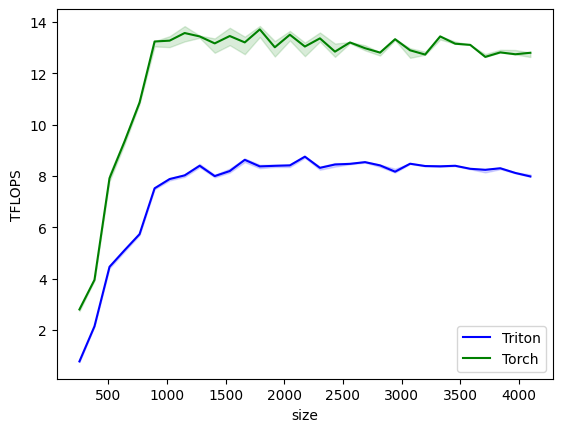

naive-triton-matmul-perf:
      size    Triton      Torch
0    256.0  0.771012   2.796203
1    384.0  2.139628   3.949714
2    512.0  4.457284   7.913781
3    640.0  5.104845   9.343599
4    768.0  5.732244  10.863988
5    896.0  7.519267  13.242326
6   1024.0  7.879864  13.275739
7   1152.0  8.023468  13.572654
8   1280.0  8.399628  13.439836
9   1408.0  7.995272  13.168541
10  1536.0  8.192000  13.456061
11  1664.0  8.629204  13.207595
12  1792.0  8.373083  13.714193
13  1920.0  8.396310  13.017332
14  2048.0  8.413059  13.506867
15  2176.0  8.753575  13.046125
16  2304.0  8.317007  13.364663
17  2432.0  8.447478  12.847221
18  2560.0  8.473102  13.205415
19  2688.0  8.539635  12.981048
20  2816.0  8.412651  12.809342
21  2944.0  8.167561  13.332272
22  3072.0  8.477544  12.898753
23  3200.0  8.387565  12.733151
24  3328.0  8.375951  13.441556
25  3456.0  8.397807  13.155993
26  3584.0  8.280360  13.110903
27  3712.0  8.239933  12.642408
28  3840.0  8.301047  12.817803
29  3968.0  8.

In [5]:
benchmark.run(show_plots=True, print_data=True)

In [6]:
torch.cuda.empty_cache()